* API: Air Quality API http://aqicn.org/api
* Name: Zaiyuan Wu
* Student Number: 22205209

In [1]:
import json
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from pandas.plotting import scatter_matrix
import seaborn as sns
%matplotlib inline

In [2]:
# The four cities I would like to study
cities = ["Shanghai", "Nanjing", "Shenzhen", "Hongkong"]
# Colors that I will use in various plots
colors = {"Shanghai":"red", "Nanjing":"orange", "Shenzhen":"blue", "Hongkong":"green"}
# Precision that I'll use for Pandas display
pd.set_option('display.precision', 2)

# Intro
This is the task 2 of assignment 1. In this notebook, I use data collected from task 1, air quality of four cities with World Air Quality Index API, to analyze trends, range, similarities, correlations and more.

## Create directory for raw data and pre-processed data

In [3]:
# directory for raw data storage
dir_raw = Path("raw")
# directory for storing clean pre-processed data
dir_data = Path("data")
# make sure it exists
dir_data.mkdir(parents=True, exist_ok=True)

In [4]:
city_path = {}
for city in cities:
    city_path[city] = []
for path in dir_raw.iterdir():
    if path.suffix == ".json":
        # get rid of suffix and split by "-"
        parts = path.stem.split("-")
        if parts[0] in cities:
            city_path[parts[0]].append(path)
for city in cities:
    print("%s: \t %d raw JSON files" % (city, len(city_path[city])))

Shanghai: 	 88 raw JSON files
Nanjing: 	 88 raw JSON files
Shenzhen: 	 88 raw JSON files
Hongkong: 	 88 raw JSON files


## Select needed data

In [5]:
fin = open(city_path["Shanghai"][0], "r")
jdata = fin.read()
data = json.loads(jdata)
# original format date time
print(data["data"]["time"]["s"])

2022-11-02 11:00:00


In [6]:
def parse_raw(city, path):
    rows = []
    fin = open(path, "r")
    jdata = fin.read()
    data = json.loads(jdata)
    # handle each observation
    row = {"City": city}
    row["Date"] = datetime.strptime(data["data"]["time"]["s"], "%Y-%m-%d %H:%M:%S")
    row["aqi"] = data["data"]["aqi"]
    row["dominent"] = data["data"]["dominentpol"]
    row["pm2.5"] =  data["data"]["iaqi"]["pm25"]["v"]
    row["pm10"] =  data["data"]["iaqi"]["pm10"]["v"]
    row["ozone"] =  data["data"]["iaqi"]["o3"]["v"]
    rows.append(row)
    fin.close()
    # return back the DataFrame
    return pd.DataFrame(rows)

In [7]:
# parse 1 JSON file as example
result = parse_raw("Nanjing", city_path["Nanjing"][0])
result

,City,Date,aqi,dominent,pm2.5,pm10,ozone
0,Nanjing,2022-11-04 04:00:00,55,pm25,55,22,31.3


## Merge data belongs to the same city

In [8]:
def parse_merge_raw(city, paths):
    df_files = []
    # process each file for this city
    print("%s:\t Parsing %d JSON files..." % (city, len(paths)))
    for path in paths:
        # produce a DataFrame from this file
        df_file = parse_raw(city, path)
        df_files.append(df_file)
    # concatenate all the DataFrames together into a single frame
    df_city = pd.concat(df_files)
    # remove duplicate data based on the Date field
    df_city.drop_duplicates(subset="Date", keep="first", inplace=True)
    # set Date as the index column
    df_city.set_index("Date", inplace=True)
    # sort the frame by its index
    return df_city.sort_index()    

In [9]:
df_cities = {}
for city in cities:
    df_city = parse_merge_raw(city, city_path[city])
    df_cities[city] = df_city

Shanghai:	 Parsing 88 JSON files...
Nanjing:	 Parsing 88 JSON files...
Shenzhen:	 Parsing 88 JSON files...
Hongkong:	 Parsing 88 JSON files...


In [10]:
df_cities["Shenzhen"].head(10)

,City,aqi,dominent,pm2.5,pm10,ozone
Date,,,,,,
2022-11-01 10:00:00,Shenzhen,72,pm25,72,51,38.2
2022-11-01 11:00:00,Shenzhen,70,pm25,70,50,37.4
2022-11-01 12:00:00,Shenzhen,72,pm25,72,49,37.4
2022-11-01 13:00:00,Shenzhen,68,pm25,68,44,37.4
2022-11-01 14:00:00,Shenzhen,65,pm25,65,40,40.7
2022-11-01 15:00:00,Shenzhen,63,pm25,63,41,40.3
2022-11-01 16:00:00,Shenzhen,68,pm25,68,43,40.3
2022-11-01 17:00:00,Shenzhen,70,pm25,70,37,39.8
2022-11-01 18:00:00,Shenzhen,65,pm25,65,35,34.2


From this table, it's easy to tell that the value of aqi and pm 2.5 seems strongly related. So I decide to explore further in the following analysis.

## Summarize start and end time of data

In [11]:
def summarize_dates():
    rows = []
    for city in cities:
        row = {"City": city}
        row["Rows"] = len(df_cities[city])
        row["Start"] = df_cities[city].index.min()
        row["End"] = df_cities[city].index.max()
        rows.append(row)
    return pd.DataFrame(rows).set_index("City")

# display the ranges
df_date_summary = summarize_dates()
df_date_summary

,Rows,Start,End
City,,,
Shanghai,69,2022-11-01 10:00:00,2022-11-05 00:00:00
Nanjing,85,2022-11-01 10:00:00,2022-11-05 01:00:00
Shenzhen,84,2022-11-01 10:00:00,2022-11-05 01:00:00
Hongkong,83,2022-11-01 10:00:00,2022-11-05 01:00:00


In [12]:
# find the latest start date
time_start = df_date_summary["Start"].max()
# find the earlier end date
time_end = df_date_summary["End"].min()
time_start, time_end

(Timestamp('2022-11-01 10:00:00'), Timestamp('2022-11-05 00:00:00'))

## Truncate the data to the same period of time

In [13]:
# truncate each dataset
for city in cities:
    df_cities[city] = df_cities[city][time_start:time_end]
# check the date ranges again
summarize_dates()

,Rows,Start,End
City,,,
Shanghai,69,2022-11-01 10:00:00,2022-11-05
Nanjing,84,2022-11-01 10:00:00,2022-11-05
Shenzhen,83,2022-11-01 10:00:00,2022-11-05
Hongkong,82,2022-11-01 10:00:00,2022-11-05


In [14]:
for city in cities:
    print(city + ":", end = "\t")
    missing_counts = df_cities[city].isnull().sum()
    # judge if there are missing values 
    missing_counts = missing_counts[missing_counts>0]
    if len(missing_counts) == 0:
        print("No missing values")
    else:
        print(missing_counts)

Shanghai:	No missing values
Nanjing:	No missing values
Shenzhen:	No missing values
Hongkong:	No missing values


## Writing processed data to new json files

In [15]:
for city in cities:
    fname = city + ".json"
    out_path = dir_data / fname
    print("Writing %s" % out_path)
    # encode json with "index" fromatting
    df_cities[city].to_json(out_path, orient="index", indent=4)

Writing data/Shanghai.json
Writing data/Nanjing.json
Writing data/Shenzhen.json
Writing data/Hongkong.json


## Read data from files

In [16]:
df_cities = {}
for city in cities:
    fname = city + ".json"
    in_path = dir_data / fname
    # read in json file with "index" decode formatting
    df_cities[city] = pd.read_json(in_path, orient="index")
    print("%s:\t%d rows of data - [%s to %s]" % 
          (city, len(df_cities[city]), 
           df_cities[city].index.min(), df_cities[city].index.max() ))

Shanghai:	69 rows of data - [2022-11-01 10:00:00 to 2022-11-05 00:00:00]
Nanjing:	84 rows of data - [2022-11-01 10:00:00 to 2022-11-05 00:00:00]
Shenzhen:	83 rows of data - [2022-11-01 10:00:00 to 2022-11-05 00:00:00]
Hongkong:	82 rows of data - [2022-11-01 10:00:00 to 2022-11-05 00:00:00]


In [17]:
df_cities["Nanjing"].head(5)

,City,aqi,dominent,pm2.5,pm10,ozone
2022-11-01 10:00:00,Nanjing,65,pm25,65,44,24.4
2022-11-01 11:00:00,Nanjing,72,pm25,72,42,37.4
2022-11-01 12:00:00,Nanjing,61,pm25,61,38,43.5
2022-11-01 13:00:00,Nanjing,55,pm25,55,33,51.3
2022-11-01 14:00:00,Nanjing,72,pm25,72,44,55.2


## Analyze AQI

In [18]:
def compute_stats(col_name):
    rows = []
    for city in cities:
        row = {"City": city}
        row["Min"] = df_cities[city][col_name].min()
        row["Max"] = df_cities[city][col_name].max()
        row["Mean"] = df_cities[city][col_name].mean()
        row["Median"] = df_cities[city][col_name].median()
        rows.append(row)
    return pd.DataFrame(rows).set_index("City")

In [19]:
df_aqi_stats = compute_stats("aqi")
df_aqi_stats

,Min,Max,Mean,Median
City,,,,
Shanghai,34,151,81.38,72.0
Nanjing,30,157,78.65,76.0
Shenzhen,29,93,58.92,57.0
Hongkong,7,79,47.09,51.0


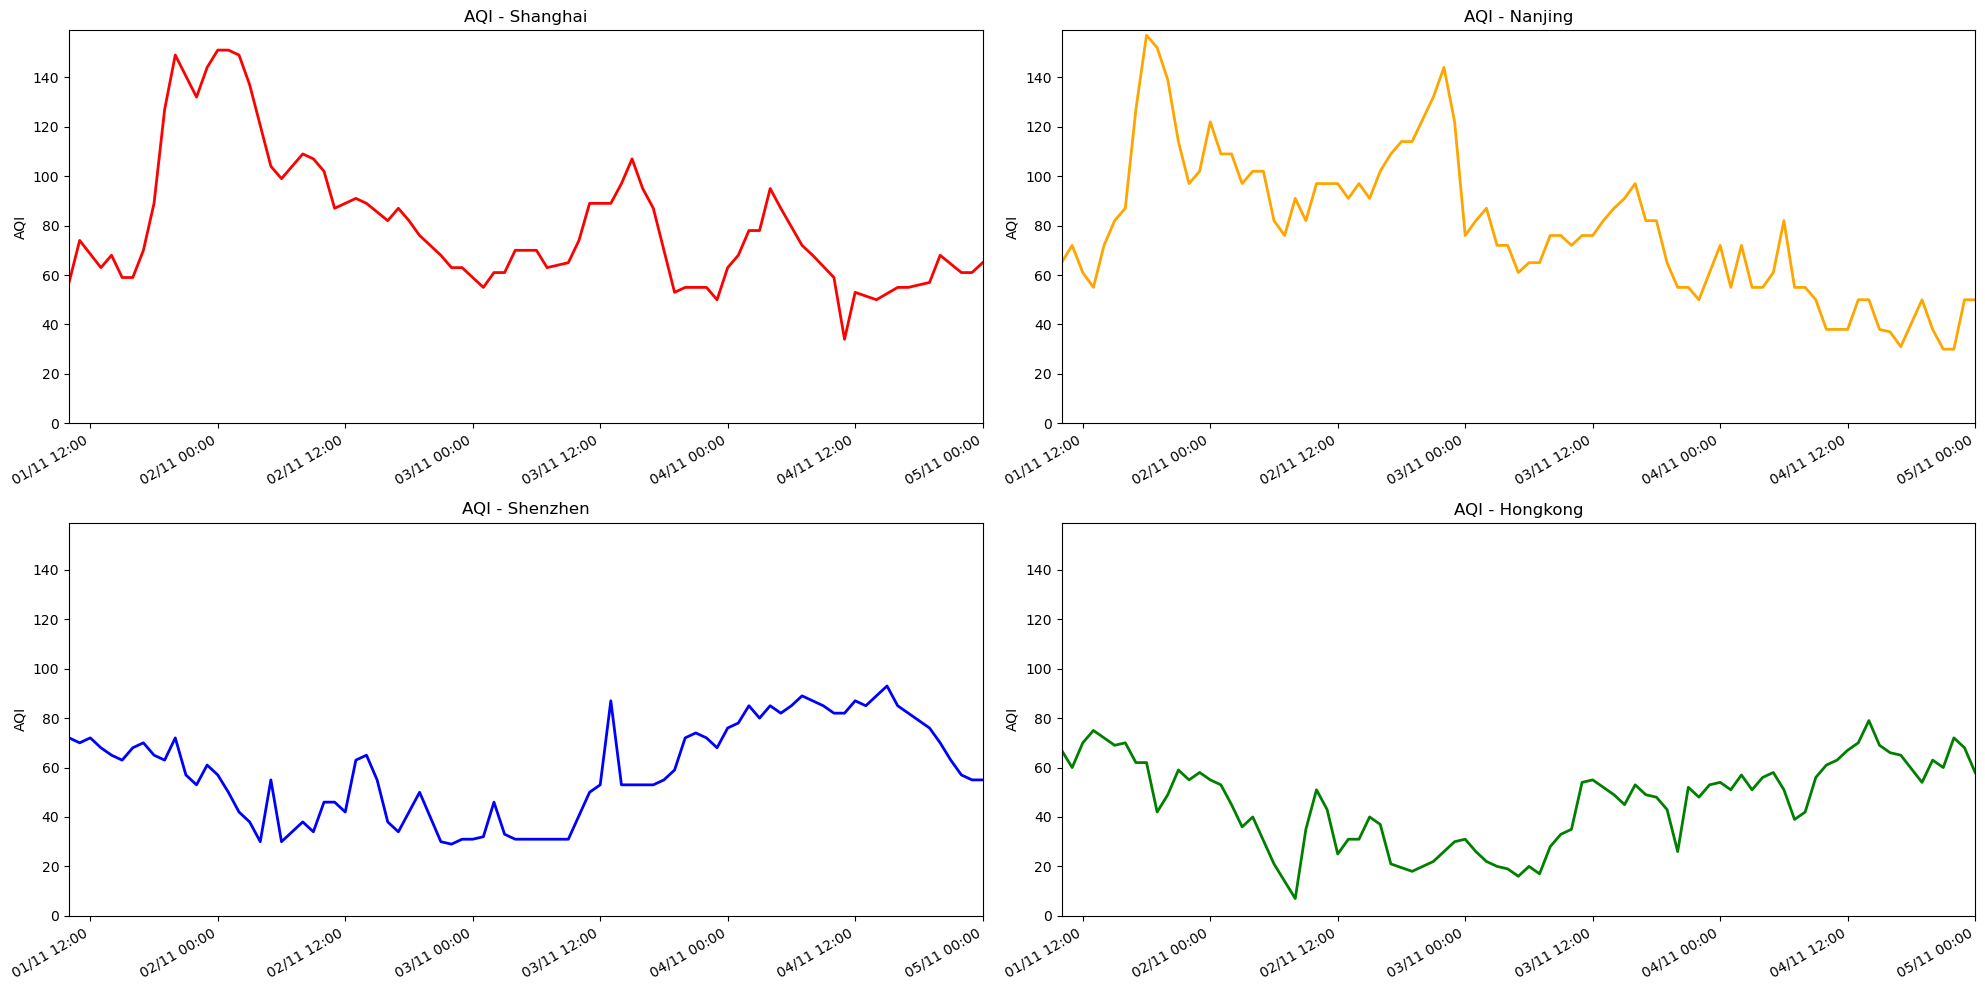

In [20]:
fig = plt.figure(figsize=(20,10))
for i, city in enumerate(cities):
    # get the axis of the subplot
    axc = fig.add_subplot(2, 2, i+1)
    ax = df_cities[city]["aqi"].plot(ax=axc, legend=False, lw=2, color=colors[city])
    ax.set_title("AQI - %s" % city)
    ax.set_ylabel("AQI")
    # Use the max value of max AQI as consistent Y-axis limit
    ax.set_ylim(0, df_aqi_stats["Max"].max()+2)
    ax.set_xlim(df_cities[city].index.min(), df_cities[city].index.max())
    # change the format of the dates on the x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:00'))    
# Adjust the padding around the subplots
fig.tight_layout()

The line chart above illustrates the trends of AQI in four cities. Shanghai and Nanjing has similar trend, and Shenzhen and Hongkong has similar trends, because they are geographically closer.

In [21]:
df_daily_aqi = {}
for city in cities:
    # groupy each index by day
    # truncate the data by time again for whole-day data
    if time_start.hour != 0:
        time_start = datetime(time_start.year, time_start.month, time_start.day+1, hour=0)
    if time_end.hour != 23:
        time_end = datetime(time_end.year, time_end.month, time_end.day-1, hour=23)
    groups = df_cities[city]["aqi"][time_start:time_end].groupby(pd.Grouper(freq='D', dropna=True))
    min_aqi = groups.min()
    max_aqi = groups.max()
    mean_aqi = groups.mean()
    median_aqi = groups.median()
    # combine the min, max, mean and median values into a new DataFrame
    df_daily_aqi[city] = pd.DataFrame({"Min": min_aqi, "Max": max_aqi, "Mean": mean_aqi, "Median": median_aqi})

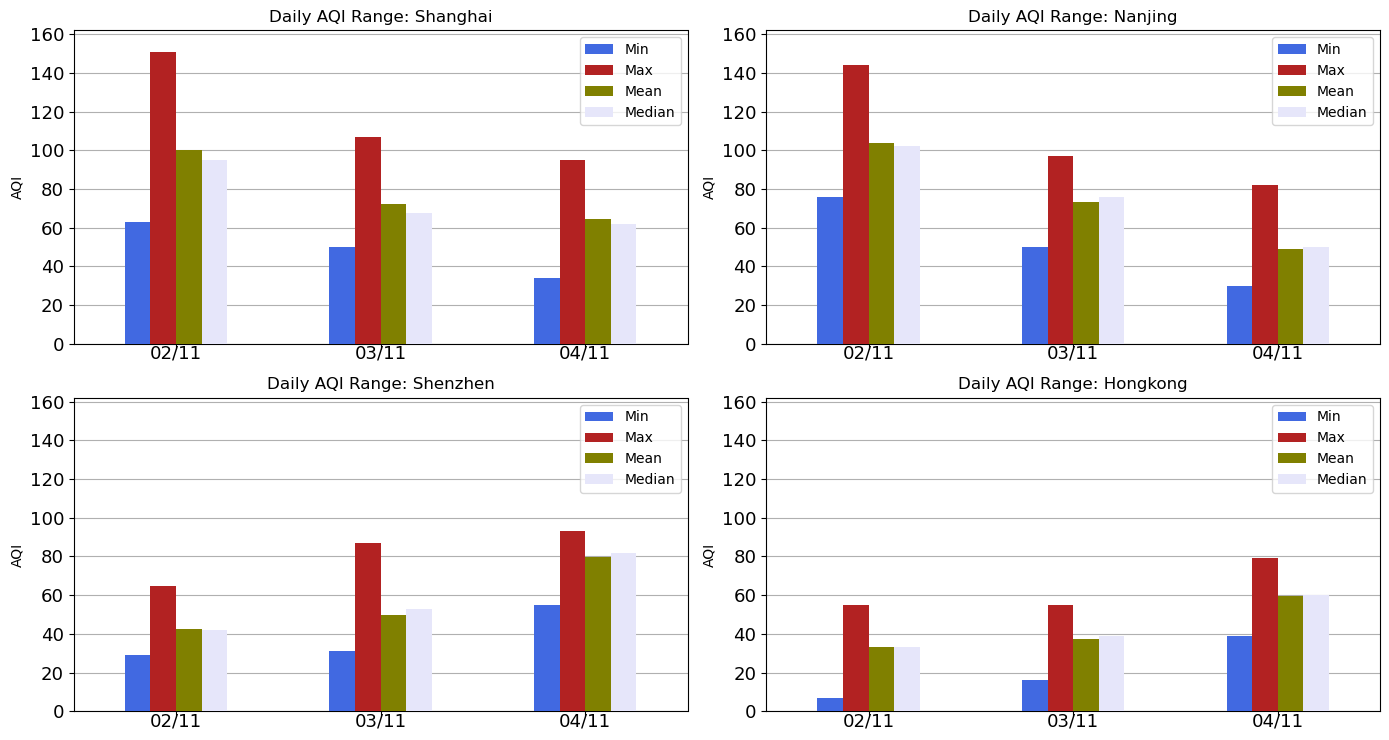

In [22]:
fig = plt.figure(figsize=(14,7.5))
for i, city in enumerate(cities):
    axc = fig.add_subplot(2, 2, i+1)
    ax = df_daily_aqi[city].plot.bar(ax=axc, y=['Min', 'Max', "Mean", "Median"], 
        color={ "Min": "royalblue", "Max": "firebrick", "Mean": "olive", "Median": "lavender"}, fontsize=13, zorder=3)
    # generate nicer x-axis labels
    ticklabels = [ d.strftime("%d/%m") for d in df_daily_aqi[city].index]
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
    ax.set_title("Daily AQI Range: %s" % city)
    ax.set_ylabel("AQI")
    ax.set_ylim(0, df_aqi_stats["Max"].max()+5)
    ax.yaxis.grid(True);
    plt.xticks(rotation=0, va='center');
fig.tight_layout()

* This figure shows the daily AQI range, including Min, Max, Mean and Median. We can see that during the four days being recorded, Shanghai and Nanjing has an obvious higher value of AQI overall, which means poorer air quality than Shenzhen and HongKong.
* This graph of 01/11 and 05/11 is actually inaccurate, bucause data starts at 10:00 01/11 and ends at 00:00 05/11. So truncate the incomplete data.
* Under this circumstance, I only analyze data from 02/11 to 04/11, it is shown that the min/max difference is quiet large in all four cities.

In [23]:
def merge_data_by_column(col_name):
    columns = {}
    for city in cities:
        columns[city] = df_cities[city][col_name]
    df_merged = pd.DataFrame(columns).sort_index()
    # drop the rows with incomplete data
    return df_merged.dropna()

In [24]:
df_aqi_merged = merge_data_by_column("aqi")
df_aqi_merged.head(5)

,Shanghai,Nanjing,Shenzhen,Hongkong
2022-11-01 10:00:00,57.0,65.0,72.0,67.0
2022-11-01 11:00:00,74.0,72.0,70.0,60.0
2022-11-01 13:00:00,63.0,55.0,68.0,75.0
2022-11-01 14:00:00,68.0,72.0,65.0,72.0
2022-11-01 15:00:00,59.0,82.0,63.0,69.0


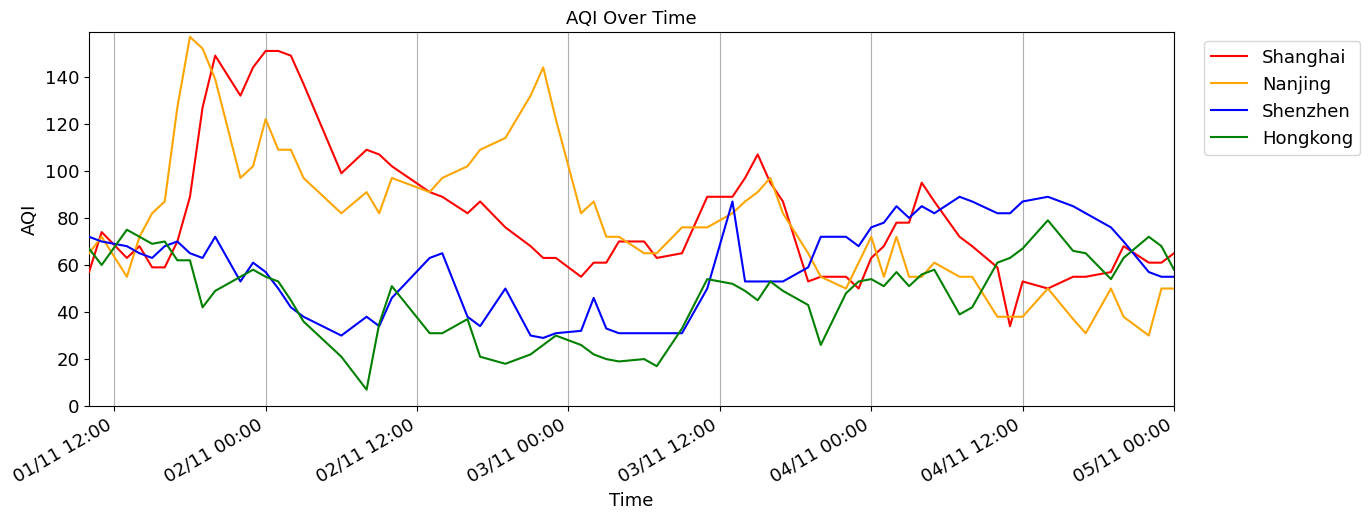

In [25]:
ax = df_aqi_merged.plot(figsize=(14,5.5), color=colors, fontsize=13, zorder=3)
ax.set_title("AQI Over Time", fontsize=13)
ax.set_xlabel("Time", fontsize=13)
ax.set_ylabel("AQI", fontsize=13)
# adjust the axis limits
ax.set_ylim(0, df_aqi_stats["Max"].max()+2)
ax.set_xlim(df_aqi_merged.index.min(), df_aqi_merged.index.max())
# change the format of the dates on the x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:00'))    
# move the legend outside the plot
ax.legend(bbox_to_anchor=(1.18, 1), fontsize=13)
# add an x grid
ax.xaxis.grid(True);

* This plot shows that Shanghai and Nanjing underwent a significant AQI rise from around 16:00 01/11, and Nanjing has another huge rise of AQI from 12:00 02/11.
* AQI of Nanjing and Shanghai is significantly higher than other two cities in 2nd and 3rd of Nov.

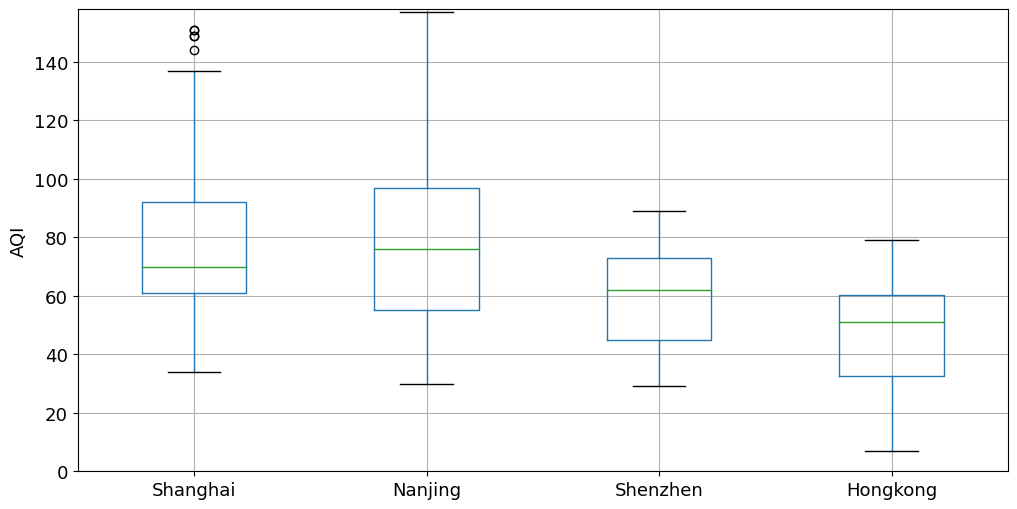

In [26]:
ax = df_aqi_merged.boxplot(figsize=(12,6), fontsize=13)
ax.set_ylim(0, df_aqi_stats["Max"].max()+1)
ax.set_ylabel("AQI", fontsize=13);

The box chart shows the distributions of AQI in four cities, Nanjing and Shanghai has poorer air quality overall. Nanjing has highest median AQI of all; and the black dots of Shanghai's plot indicates unusual peak AQI during the recorded period of time.

## Count dominent pollution

In [27]:
text_counts = {}
for city in cities:
    counts = df_cities[city]["dominent"].value_counts()
    # convert to percentage
    text_counts[city] = (counts*100.0)/len(df_cities[city])
# convert to a DataFrame and fill the missing value with 0s
df_text_counts = pd.DataFrame(text_counts).fillna(0)
df_text_counts

,Shanghai,Nanjing,Shenzhen,Hongkong
o3,0.0,2.38,12.05,13.41
pm10,0.0,0.00,0.00,1.22
pm25,100.0,97.62,87.95,85.37


In [28]:
df_text_counts.idxmax()

Shanghai    pm25
Nanjing     pm25
Shenzhen    pm25
Hongkong    pm25
dtype: object

The main pollution in the four cities is all pm 2.5.

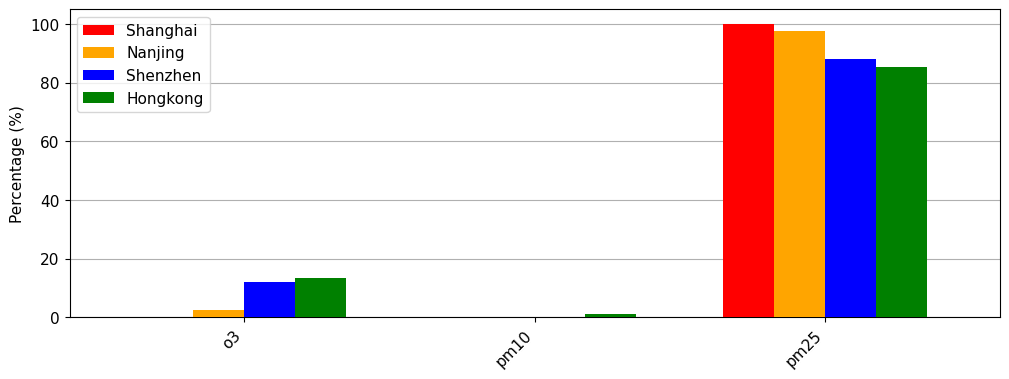

In [29]:
ax = df_text_counts.plot.bar(figsize=(12,4), width=0.7, fontsize=11, color=colors, zorder=3)
ax.legend(fontsize=11)
ax.set_ylabel("Percentage (%)", fontsize=11)
ax.yaxis.grid(True)
# adjust the x-axis label rotation
plt.xticks(rotation=45, ha='right');

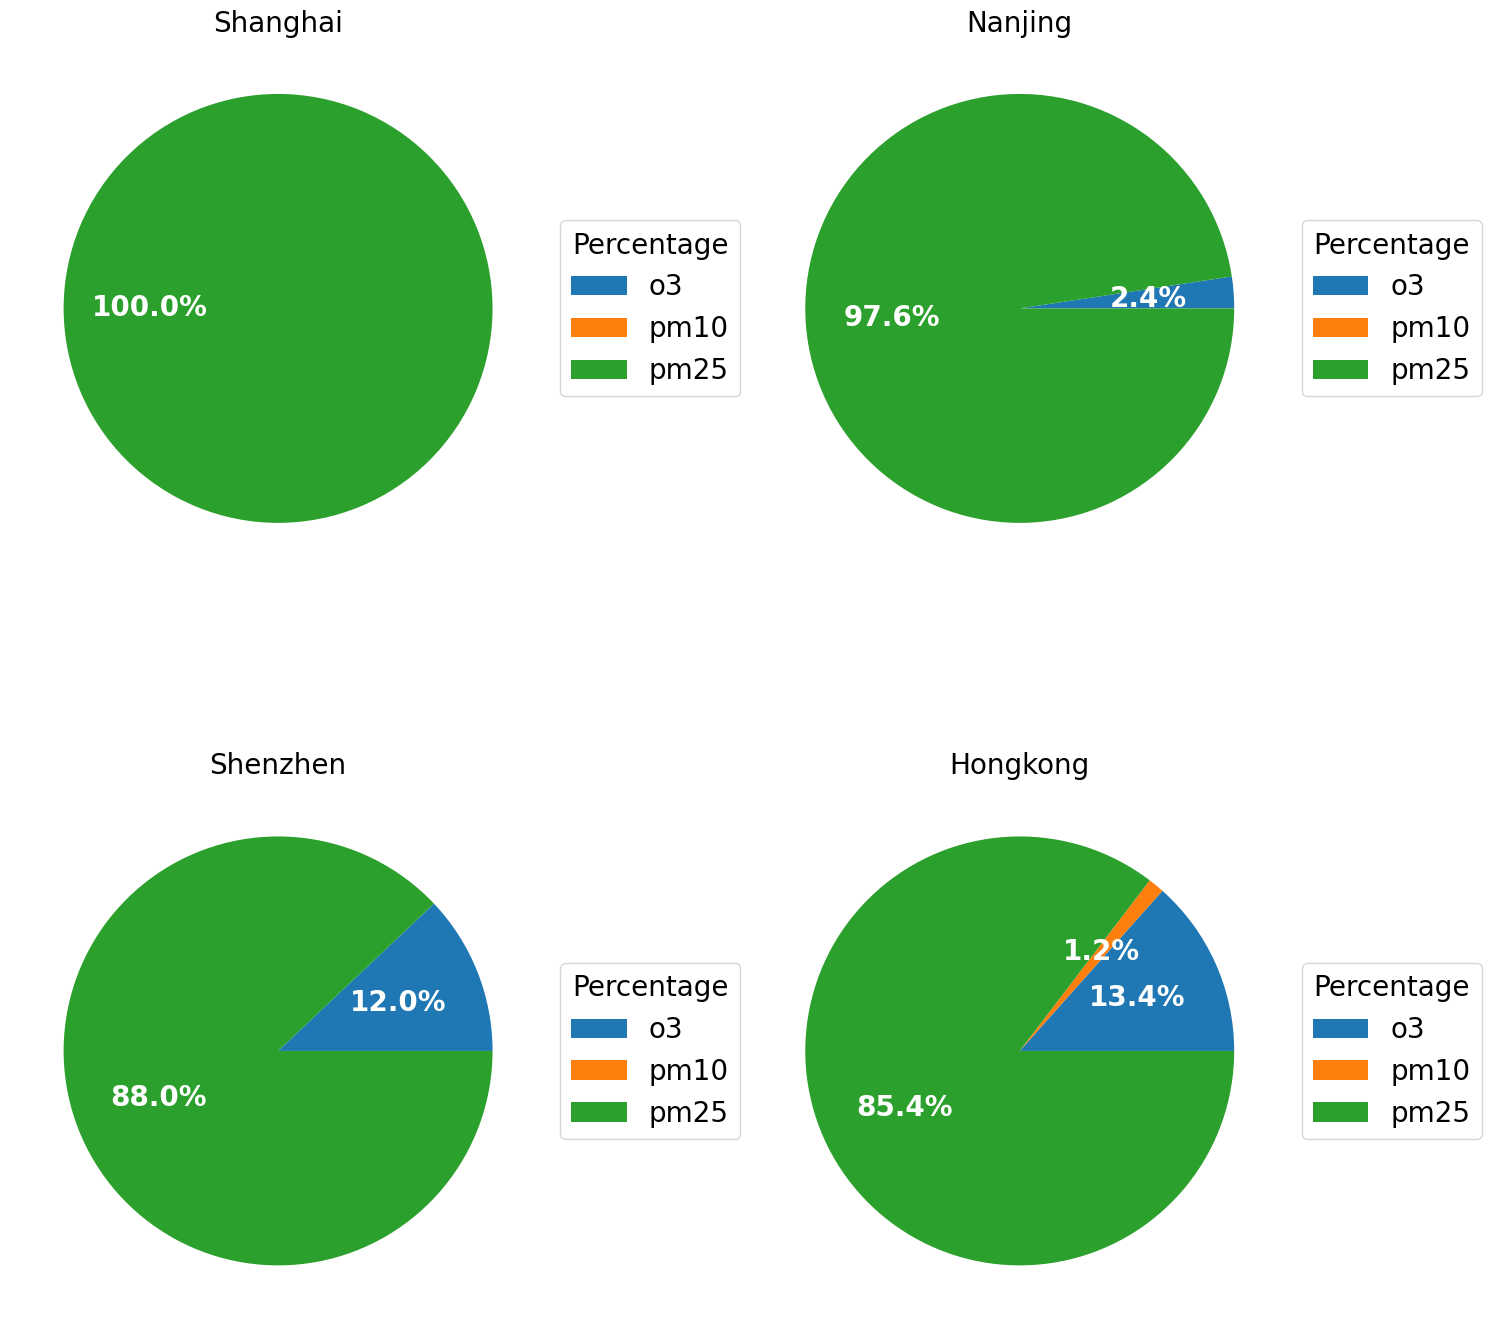

In [30]:
fig = plt.figure(figsize=(15,15))
# function to calculate the percentage of wedges
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    if pct == 0:
        return
    return "{:.1f}%".format(pct)
for i, city in enumerate(cities):
    axc = fig.add_subplot(2, 2, i+1)
    wedges, texts, autotexts = axc.pie(df_text_counts[city], autopct=lambda pct: func(pct, df_text_counts[city]),textprops=dict(color="w"))
    plt.setp(autotexts, size=20, weight="bold")
    axc.legend(wedges, df_text_counts.index,
          title="Percentage", title_fontsize=20,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1), fontsize=20)
    axc.set_title(label=city, loc='center', size=20)
fig.tight_layout()

The dominent pollution of four cities is pm 2.5 in most time, but ozone become dominent sometimes in Nanjing, Shenzhen and Hongkong; pm 10 become dominent in Hongkong as well.

## Compare AQI with pm 2.5

In [31]:
def merge_char_by_col(city, col1, col2):
    columns = {}
    for city in cities:
        columns[col1] = df_cities[city][col1]
        columns[col2] = df_cities[city][col2]
    df_merged = pd.DataFrame(columns).sort_index()
    return df_merged.dropna()

In [32]:
df_char_merged = merge_char_by_col("Nanjing", "aqi", "pm2.5")
df_char_merged.head(5)

,aqi,pm2.5
2022-11-01 10:00:00,67,67
2022-11-01 11:00:00,60,60
2022-11-01 12:00:00,70,70
2022-11-01 13:00:00,75,75
2022-11-01 14:00:00,72,72


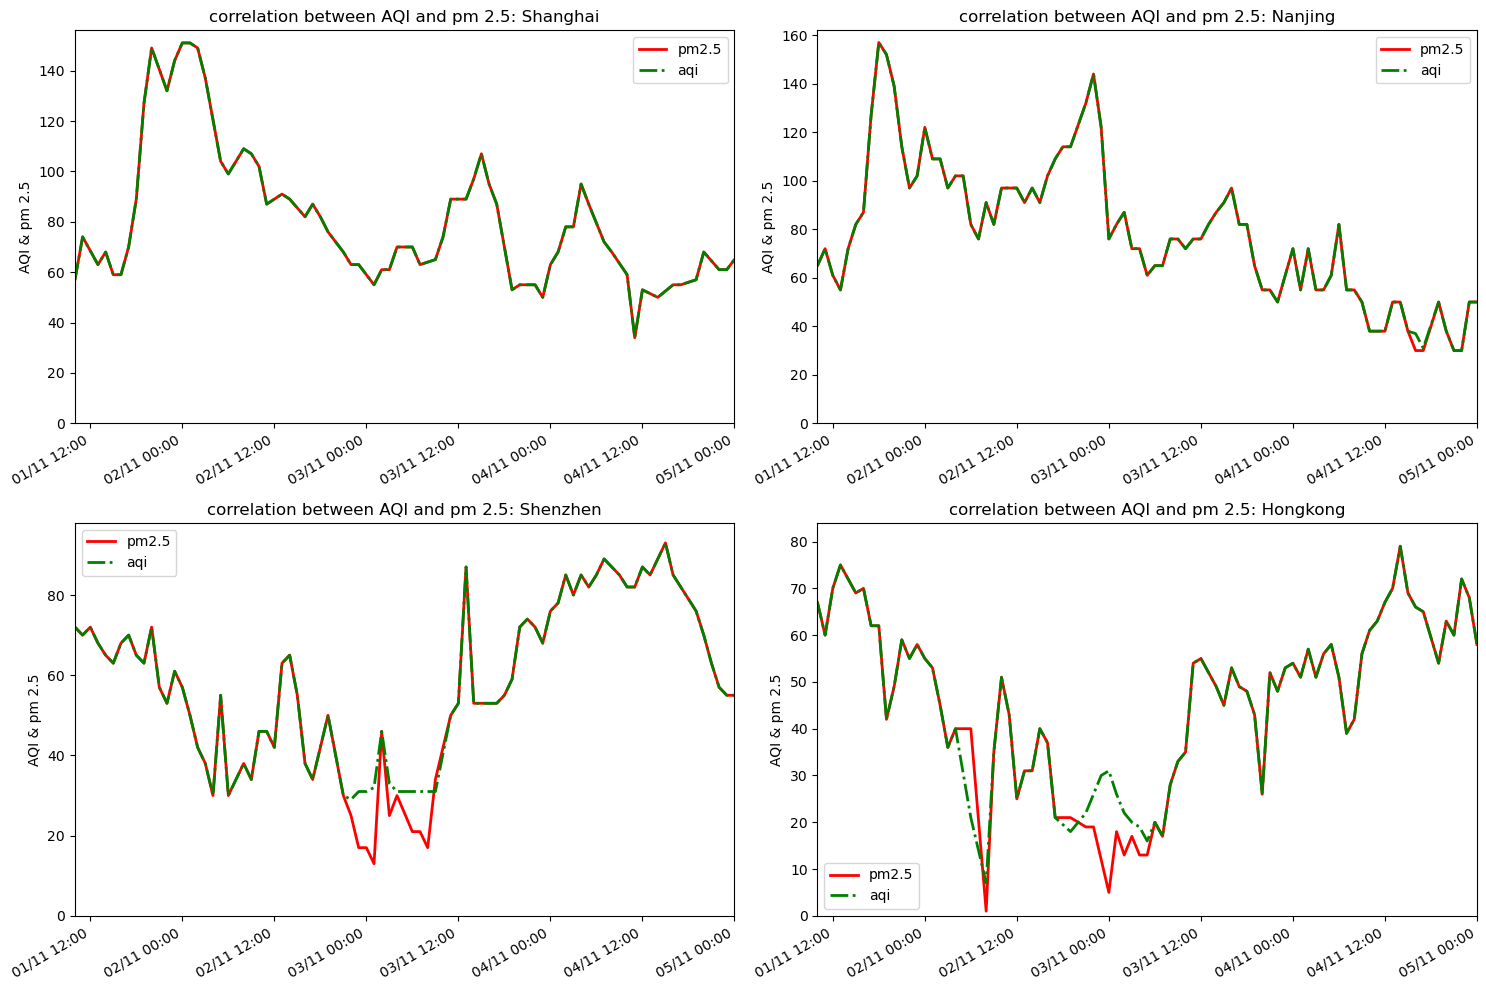

In [33]:
fig = plt.figure(figsize=(15,10))
for i, city in enumerate(cities):
    # create a subplot
    axc = fig.add_subplot(2, 2, i+1)
    # generate the plot for this city
    ax = df_cities[city]["pm2.5"].plot(ax=axc, legend=False, lw=2, color="red")
    ax = df_cities[city]["aqi"].plot(ax=axc, legend=False, lw=2, color="green", linestyle="dashdot")
    ax.legend()
    ax.set_title("correlation between AQI and pm 2.5: %s" % city)
    ax.set_ylabel("AQI & pm 2.5")
    # set the Y-axis limit to the max value of aqi and pm2.5, whichever is bigger
    ax.set_ylim(0, max(df_cities[city]["aqi"].max(),df_cities[city]["pm2.5"].max())+5)
    ax.set_xlim(df_cities[city].index.min(), df_cities[city].index.max())
    # change the format of the dates on the x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:00'))        
# fix the padding around plots
fig.tight_layout()

The red curve overlaps the green curve in the plots above; Shanghai's AQI completely equals to pm 2.5, in all cities, AQI equals pm 2.5 in most cases.

## Compare the correlations of the four variables

In [34]:
# the columns to focus on
target_columns = ["aqi", "pm2.5", "pm10", "ozone"]

In [35]:
all_dfs = []
for city in cities:
    all_dfs.append(df_cities[city].reset_index())
# concatendate all of the DataFrames into a single stacked frame
df_all = pd.concat(all_dfs)
df_all.head()

,index,City,aqi,dominent,pm2.5,pm10,ozone
0,2022-11-01 10:00:00,Shanghai,57,pm25,57,31,38.2
1,2022-11-01 11:00:00,Shanghai,74,pm25,74,30,39.0
2,2022-11-01 13:00:00,Shanghai,63,pm25,63,30,41.5
3,2022-11-01 14:00:00,Shanghai,68,pm25,68,29,40.7
4,2022-11-01 15:00:00,Shanghai,59,pm25,59,21,40.7


In [36]:
df_all_target = df_all[target_columns]
df_all_target.head()

,aqi,pm2.5,pm10,ozone
0,57,57,31,38.2
1,74,74,30,39.0
2,63,63,30,41.5
3,68,68,29,40.7
4,59,59,21,40.7


In [37]:
def plot_heatmap(title, df_in, figsize=(5, 5)):
    # get the correlation matrix
    df_corr = df_in.corr()
    # select a color palette by name
    cmap = "crest"
    # display the heatmap
    f, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df_corr, square=True, cbar=False, annot=True, cmap=cmap, linewidths=0.5, vmin=-1)
    ax.set_title(title)

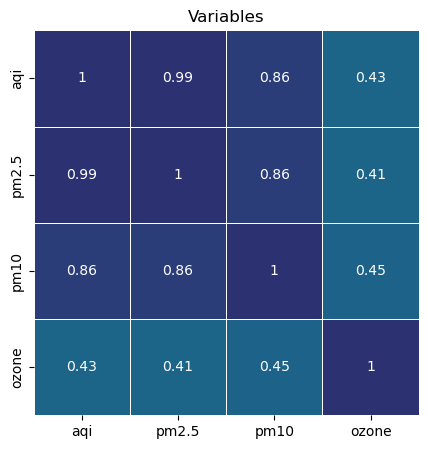

In [38]:
plot_heatmap("Variables", df_all_target)

From the heatmap above, we can see that the correlation between AQI and pm 2.5 is 0.99, which indicates that these two variables have strong correlations. That between AQI and pm 10 is 0.86, which is high as well.

## Classify the pollution level by AQI
* Good:                           0-50
* Moderate:                       51-100
* Unhealthy for Sensitive Groups: 101-150
* Unhealthy:                      151-200
* Very Unhealthy:                 201-300
* Hazardous:                      301-

In [39]:
rows = []
# create a DataFrame with overall percentage for different pollution categories
for city in cities:
    row = {"Good":0, "Moderate":0, "Unhealthy for Sensitive Groups":0, "Unhealthy":0, "Very Unhealthy":0, "Hazardous":0}
    for i, value in df_cities[city]["aqi"].iteritems():
        if value <= 50:
            row["Good"] += 1
        elif value <= 100:
            row["Moderate"] += 1
        # any rain at all?
        elif value <= 150:
            row["Unhealthy for Sensitive Groups"] += 1
        elif value <= 200:
            row["Unhealthy"] += 1
        elif value <= 300:
            row["Very Unhealthy"] += 1
        else:
            row["Hazardous"] += 1
    # convert numbers to percentages
    for key in row:
        row[key] = (100.0*row[key])/len(df_cities[city])
    row["City"] = city
    rows.append(row)
df_pol_levels = pd.DataFrame(rows).set_index("City")
# put the cities on columns
df_pol_levels = df_pol_levels.transpose()
df_pol_levels

City,Shanghai,Nanjing,Shenzhen,Hongkong
Good,4.35,19.05,33.73,47.56
Moderate,75.36,59.52,66.27,52.44
Unhealthy for Sensitive Groups,17.39,19.05,0.00,0.00
Unhealthy,2.90,2.38,0.00,0.00
Very Unhealthy,0.00,0.00,0.00,0.00
Hazardous,0.00,0.00,0.00,0.00


From this chart we can see that Shenzhen and Hongkong always controls their air quality better than "Moderate"(including), but Nanjing and Shanghai can reach "unhealthy" in the worst scenario.

## Analyze similarity between cities using euclidean distance

In [40]:
X = df_pol_levels.transpose()
D = euclidean_distances(X)
D

array([[ 0.        , 21.67841269, 35.45732121, 51.99723823],
       [21.67841269,  0.        , 25.09267974, 35.09539013],
       [35.45732121, 25.09267974,  0.        , 19.55296741],
       [51.99723823, 35.09539013, 19.55296741,  0.        ]])

In [41]:
for i, city in enumerate(cities):
    dmin, dmax = 0, 0
    city_min, city_max = None, None
    # find the nearest euclidean distance
    for j in range(len(cities)):
        # skip the diagonal
        if i == j:
            continue
        if city_min is None or D[i,j] < dmin:
            dmin = D[i,j]
            city_min = cities[j]
        if city_max is None or D[i,j] > dmax:
            dmax = D[i,j]
            city_max = cities[j]  
    print("%s:\t Most similar to %s, least similar to %s" % (city, city_min, city_max))

Shanghai:	 Most similar to Nanjing, least similar to Hongkong
Nanjing:	 Most similar to Shanghai, least similar to Hongkong
Shenzhen:	 Most similar to Hongkong, least similar to Shanghai
Hongkong:	 Most similar to Shenzhen, least similar to Shanghai


# Conclusion
* During the recorded period of time, the dominent pollution in the four cities is pm 2.5 in most cases; AQI has the strongest correlation with pm 2.5. Shanghai and Nanjing share similar trend while Shenzhen and HongKong share similar trend due to geographgical reason.
* Under worst scenario, Shanghai and Nanjing could have unhealthy air quality, while ShenZhen and Hongkong always keep air quality better.
***
* For this assignment, at first I tried the ticketmaster and genius API, but could not get any useful information for analysis i.e. numeric data or continuous data that have value for analyzing; Then I tried the Youtube API, but Youtube only update its data every 24-72 hour, I could not get enough data by the deadline of this assignment, so finally I decided to use this air quality API. This API gives clear and continuous real-time value of air quality data, and the authentication is easy to use.
* This API can only access real-time data, but the historical data can be downloaded from database in csv format, if more data is needed in the future for further analysis, we can convert the csv files in data frame format and do the same analysis.
* The data from api contains forcast of the next week of AQI, pm 2.5, pm 10, ozone; in the future, we can compare the prediction to the actual result and look into the accuracy of prediction.
* If more data can be captured in the future, I can predict the trend of the pollution.